METADATA
<br>
000CT: Paris 6ème - Saint Germain des Prés
<br>
Source: www.infoclimat.fr
<br>
License Ouverte/Open License: http://wiki.data.gouv.fr/images/9/9d/Licence_Ouverte.pdf
<br>
<br>
temperature = degC
<br>
pression = hPa
<br>
humidite = %
<br>
point_de_rosee = degC
<br>
vent_moyen = km/h
<br>
vent_rafales = km/h
<br>
vent_direction = deg
<br>
pluie_3h = mm
<br>
pluie_1h = mm

### Importation des librairies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

### Lecture du fichier `export_infoclimat.csv`

In [2]:
data = pd.read_csv('export_infoclimat.csv', sep=';')
data

,station_id,dh_utc,temperature,pression,humidite,point_de_rosee,vent_moyen,vent_rafales,vent_direction,pluie_3h,pluie_1h
0,000CT,2019-01-01 00:00:00,9.1,1037.3,84.0,6.5,4.8,NaN,287.0,0.0,0.0
1,000CT,2019-01-01 00:30:00,8.8,1037.2,86.0,6.6,6.4,NaN,284.0,NaN,NaN
2,000CT,2019-01-01 06:00:00,8.9,1036.1,81.0,5.8,6.4,NaN,332.0,0.0,0.0
3,000CT,2019-01-01 06:30:00,9.0,1036.2,81.0,5.9,6.4,NaN,329.0,NaN,NaN
4,000CT,2019-01-01 07:00:00,8.9,1036.3,81.0,5.9,4.8,NaN,325.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
144640,000CT,2024-03-28 10:40:00,10.3,990.3,67.0,4.4,12.9,NaN,165.0,NaN,NaN
144641,000CT,2024-03-28 10:50:00,10.4,990.3,66.0,4.3,14.5,NaN,173.0,NaN,NaN
144642,000CT,2024-03-28 11:00:00,11.1,990.5,62.0,4.1,17.7,NaN,172.0,0.0,0.0
144643,000CT,2024-03-28 11:10:00,11.1,990.5,62.0,4.1,19.3,NaN,182.0,NaN,NaN


### Listing des valeurs `null` et `NaN`

In [3]:
missing_values = data.isnull().sum()
missing_values

station_id             0
dh_utc                 0
temperature           97
pression               0
humidite              98
point_de_rosee        98
vent_moyen           190
vent_rafales      144645
vent_direction        99
pluie_3h           99448
pluie_1h           99897
dtype: int64

### Attribution des données médian à la place de `NaN` pour les colonnes `tempeareture`, `humidite`, `point_de_rosee`, `vent_moyen` et `vent_direction`
### Retrait de la colonne `vent_rafales`
### Attribution de la valeur `0` dans les colonnes `pluie_3h` et `pluie_1h` si `NaN`

In [4]:
# Fonction pour remplacer les valeurs manquantes par la médiane des 3 précédents et 3 suivants
def remplacer_par_median_locale(df, colonne):
    for i in df[colonne].index[df[colonne].isnull()]:
        valeurs_valides = df[colonne][max(i-3,0) : min(i+4, len(df[colonne]))]  # Récupérer les valeurs autour de la valeur manquante
        median_locale = valeurs_valides.median()  # Calculer la médiane locale
        df.at[i, colonne] = median_locale  # Remplacer la valeur manquante par la médiane locale
        pass
    return df

# Appliquer la fonction aux colonnes spécifiées
colonnes = ['temperature', 'humidite', 'point_de_rosee', 'vent_moyen', 'vent_direction']
for col in colonnes:
    data = remplacer_par_median_locale(data, col)
    pass

data.drop(columns=['vent_rafales'], inplace=True)

data['pluie_3h'] = data['pluie_3h'].fillna(0)
data['pluie_1h'] = data['pluie_1h'].fillna(0)

data.isnull().sum()

station_id        0
dh_utc            0
temperature       0
pression          0
humidite          0
point_de_rosee    0
vent_moyen        0
vent_direction    0
pluie_3h          0
pluie_1h          0
dtype: int64

### Retrait de la colonne `station_id` et mise en format `datetime` de la colonne `dh_utc`

In [5]:
data.drop(columns=['station_id'], inplace=True)
data['dh_utc'] = pd.to_datetime(data['dh_utc'])
data

,dh_utc,temperature,pression,humidite,point_de_rosee,vent_moyen,vent_direction,pluie_3h,pluie_1h
0,2019-01-01 00:00:00,9.1,1037.3,84.0,6.5,4.8,287.0,0.0,0.0
1,2019-01-01 00:30:00,8.8,1037.2,86.0,6.6,6.4,284.0,0.0,0.0
2,2019-01-01 06:00:00,8.9,1036.1,81.0,5.8,6.4,332.0,0.0,0.0
3,2019-01-01 06:30:00,9.0,1036.2,81.0,5.9,6.4,329.0,0.0,0.0
4,2019-01-01 07:00:00,8.9,1036.3,81.0,5.9,4.8,325.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
144640,2024-03-28 10:40:00,10.3,990.3,67.0,4.4,12.9,165.0,0.0,0.0
144641,2024-03-28 10:50:00,10.4,990.3,66.0,4.3,14.5,173.0,0.0,0.0
144642,2024-03-28 11:00:00,11.1,990.5,62.0,4.1,17.7,172.0,0.0,0.0
144643,2024-03-28 11:10:00,11.1,990.5,62.0,4.1,19.3,182.0,0.0,0.0


### Calcul de l'indice de chaleur

In [6]:
# data['dh_utc'] = pd.to_datetime(data['dh_utc'])

# # Ajouter des caractéristiques pour l'heure et le mois
# data['heure'] = data['dh_utc'].dt.hour
# data['mois'] = data['dh_utc'].dt.month

# # Fonction pour calculer l'indice de chaleur (approximation simple)
# def calculer_indice_chaleur(temp_celsius, humidite):
#     temp_fahrenheit = 9/5 * temp_celsius + 32
#     indice = -42.379 + 2.04901523*temp_fahrenheit + 10.14333127*humidite \
#             - 0.22475541*temp_fahrenheit*humidite - 6.83783*10**-3*temp_fahrenheit**2 \
#             - 5.481717*10**-2*humidite**2 + 1.22874*10**-3*temp_fahrenheit**2*humidite \
#             + 8.5282*10**-4*temp_fahrenheit*humidite**2 - 1.99*10**-6*temp_fahrenheit**2*humidite**2
#     return (indice - 32) * 5/9  # Convertir en Celsius pour le retour

# # Ajout de l'indice de chaleur au DataFrame
# data['indice_chaleur'] = data.apply(lambda row: calculer_indice_chaleur(row['temperature'], row['humidite']), axis=1)

# # Vérification des premières lignes pour s'assurer que la colonne a été ajoutée correctement
# data[['temperature', 'humidite', 'indice_chaleur']].head()

In [7]:
# data

### Classification de la colonne `pluie_1h` selon les paramètres `temperature`, `pression`, `humidite` et `vent_moyen`

In [8]:
# Récupération des paramètres
X = data[['temperature', 'pression', 'humidite', 'vent_moyen']]
y = (data['pluie_1h'] > 0).astype(int) # 1 = pluie 0 = pas pluie

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle de forêt aléatoire
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation de la performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9722423865325452
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     28215
           1       0.12      0.02      0.03       714

    accuracy                           0.97     28929
   macro avg       0.55      0.51      0.51     28929
weighted avg       0.95      0.97      0.96     28929



In [9]:
# Création du répertoire models s'il n'existe pas
if not os.path.exists('./models'):
    os.mkdir('models')
    pass

# Stockage du model de classification en pickle
pickle.dump(model, open('./models/classification_model.pickle', 'wb'))

### Réutilisation du model

In [10]:
# Chargement du modèle depuis le fichier pickle
model = pickle.load(open('./models/classification_model.pickle', 'rb'))

In [11]:
# Initialisation des données de test
temperature = 15
pression = 1010
humidite = 80
vent_moyen = 5

exemple_entree = pd.DataFrame([[temperature, pression, humidite, vent_moyen]], columns=['temperature', 'pression', 'humidite', 'vent_moyen'])
exemple_entree

,temperature,pression,humidite,vent_moyen
0,15,1010,80,5


In [12]:
# Prédiction selon mes données de test
prediction = model.predict(exemple_entree)

# Afficher le résultat de la prédiction
if prediction[0] == 1:
    print('Il va probablement pleuvoir.')
    pass
else:
    print('Il ne devrait pas pleuvoir.')
    pass

Il ne devrait pas pleuvoir.


### Affichage de différent graphique

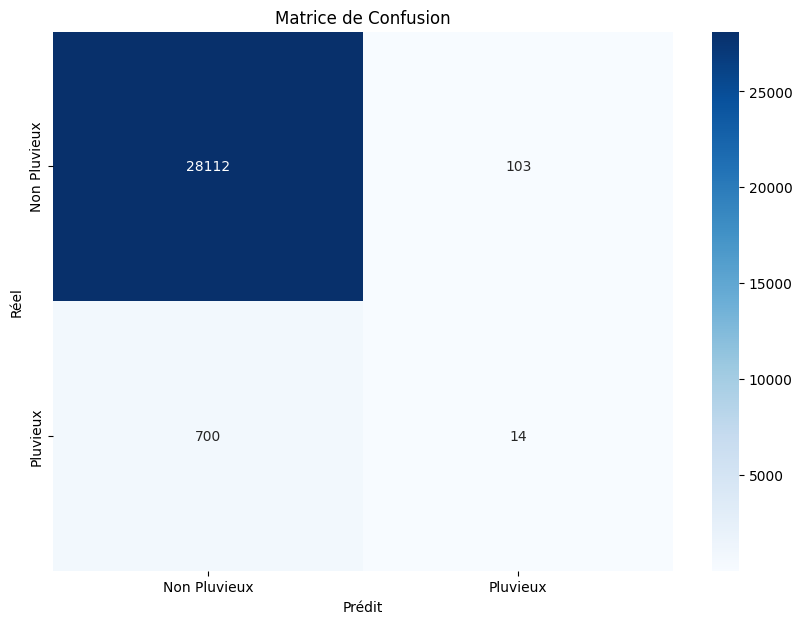

In [13]:
# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Pluvieux', 'Pluvieux'], yticklabels=['Non Pluvieux', 'Pluvieux'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion')
plt.show()

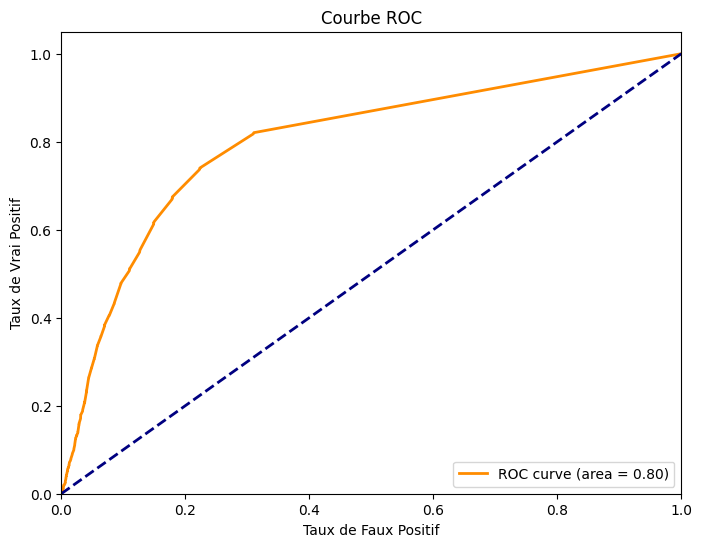

In [14]:
# Calcul des taux de faux positifs et vrais positifs
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

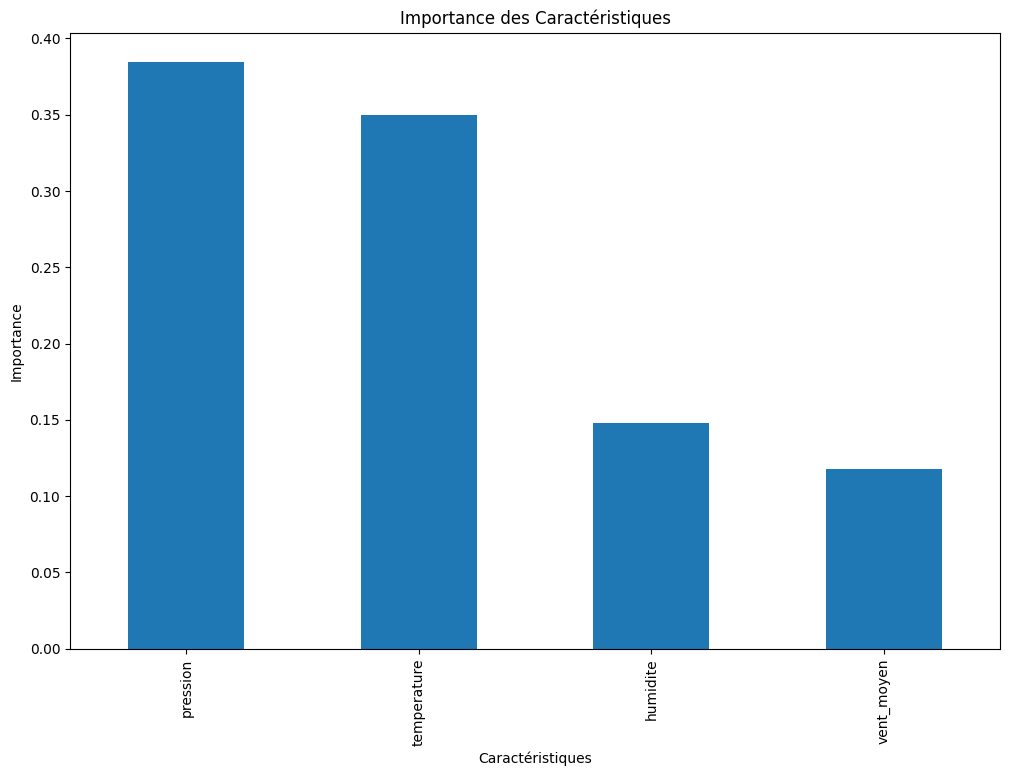

In [15]:
# Affichage de l'importance des caractéristiques
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(12,8))
feature_importances.plot(kind='bar')
plt.title('Importance des Caractéristiques')
plt.xlabel('Caractéristiques')
plt.ylabel('Importance')
plt.show()

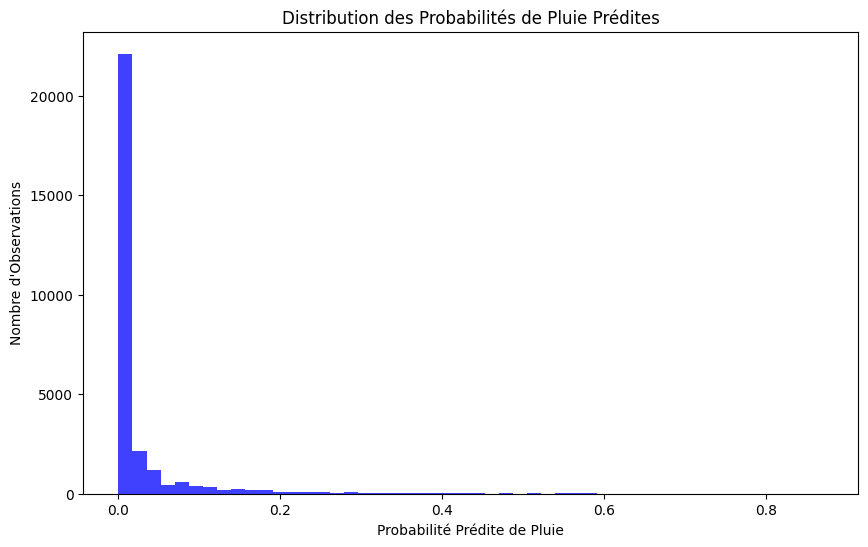

In [16]:
# Calculer les probabilités de pluie pour l'ensemble de test
probabilites_pluie = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(probabilites_pluie, bins=50, alpha=0.75, color='blue')
plt.title('Distribution des Probabilités de Pluie Prédites')
plt.xlabel('Probabilité Prédite de Pluie')
plt.ylabel('Nombre d\'Observations')
plt.show()